# Learning the model

This is the procedure I have for learning the parameters of the sparse model on one qubit.

In [2]:
#helper libraries
import numpy as np
from numpy.random import rand
import math
import scipy.optimize
import matplotlib.pyplot as plt

#qiskit functionalities
from qiskit import Aer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram

#noise model stuff
from qiskit.providers.aer.noise import NoiseModel, kraus_error, pauli_error
    
#operator info
from qiskit.quantum_info import PauliList, Pauli, Kraus
from qiskit.circuit.library import XGate

Define the terms
$$
\vec\lambda, \mathcal{F}, \mathcal{T}, \vec \omega
$$
Where $\vec \lambda$ is a list of the coefficients, $\mathcal{F}$ is the set of Pauli operators, $\mathcal{T}$ is the set of operators in the sparse model, and $\vec \omega$ is the transformed coefficients in the noise model (Eq. S9)

In [3]:
n = 1 #Number of qubits
T = PauliList(['I', 'X', 'Y', 'Z']) #List of Pauli operators
F = PauliList(['I','X', 'Y', 'Z']) #Pauli operators considered in the sparse model
coeffs = [0,.01, .05, .0085] #lambda coefficients for the model Paulis

Eq. S9: 
$$
\omega_k = \frac{1}{2}(1+e^{-2\lambda_k})
$$

In [4]:
omegas = []
for (k, lambdak) in enumerate(coeffs):
    omegas.append(.5*(1+math.exp(-2*lambdak)))

Defining the simplectic inner product, a function such that
$$
\langle P_a, P_b \rangle_{sp} = 
\begin{cases}
0 & [P_a, P_b] = 0 \\
1 & \text{else}
\end{cases}
$$
This is expressed in a matrix $M(\mathcal{T}, \mathcal{F})_{ab} = \langle T_a, F_b \rangle_{sp}$ to simplify equation (S10)

In [5]:
def s_prod(a, b):
    if(a.compose(b) == b.compose(a)):
        return 0
    else:
        return 1

M = np.zeros([len(F),len(T)])
for (i,a) in enumerate(F):
    for (j,b) in enumerate(T):
        M[i,j] = s_prod(a,b)
        

ideal_fidelities is the ideal $\vec f$ (with components $f_a$) giving the fidelities for each element in $\mathcal{F}. This is computed using Eq. (S11),
$$
-\log(\vec f)/2 = M\vec \lambda
$$

In [6]:
ideal_fidelities = np.exp(-2*np.dot(M, coeffs))
print(ideal_fidelities)

[1.         0.88958519 0.96367614 0.88692044]


The model fidelities can be converted to Pauli coefficients using the simplectic Hadamard transformation,
$$
c_b = \frac{1}{2^n} \sum_a (-1)^{\langle P_a, P_b\rangle_{sp}}f_a
$$
These convert the diagonal transfer matrix to a diagonal $\chi$ matrix. There seems to be something wrong with the normalization given in the text, am I doing something wrong?

In [7]:
#Do all 4^n-1 fidelities need to be measured or can some be omitted?
def WHtransform(b, ideal_fidelities, F):
    c_b = 0
    P_b = F[b]
    for (f_a, P_a) in zip(ideal_fidelities, F):
        c_b += (-1)**s_prod(P_a, P_b)*f_a
    c_b /= 4**n #text gives normalization 2**n
    return c_b

M = np.zeros([len(F),len(T)])
for (i,a) in enumerate(F):
    for (j,b) in enumerate(T):
        M[i,j] = s_prod(a,b)

chi = []
for b in range(len(T)):
    chi.append(WHtransform(b, ideal_fidelities, F))
    
print(chi)

[0.9350454413074056, 0.00974715527430009, 0.04679262636712117, 0.008414777051173161]


Use the resulting diagonal process matrix to create a pauli channel
$$
\Lambda(\rho) = \sum_{i}\chi_i P_i \rho P_i
$$

In [8]:
#Pauli error channel
pauli_error_channel = pauli_error(zip(F, chi))
pauli_noise_model = NoiseModel()
pauli_noise_model.add_all_qubit_quantum_error(pauli_error_channel, ['id', 'rz', 'sx'])
pauli_basis_gates = pauli_noise_model.basis_gates

This is an alternative expression of the noise model through Kraus operators according to Eq. (1):
$$
\Lambda(\rho) = \prod_{k \in \kappa} \left(\omega_k \rho + (1-\omega_k)P_k \rho P_k\right)
$$
where the product symbol denotes composition

In [9]:
#Build list of Kraus Operators
kraus_ops = Kraus(np.identity(2**n))
for (P,omega,lambdak) in zip(T, omegas, coeffs):
   if lambdak != 0:
        op = Kraus([P.to_matrix()*np.sqrt(1-omega),np.sqrt(omega)*np.identity(2**n).astype(complex)])
        kraus_ops = kraus_ops.compose(op)

/home/ben/.local/lib/python3.10/site-packages/qiskit/quantum_info/operators/channel/kraus.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if isinstance(data, np.ndarray) or np.array(data).ndim == 2:


In [10]:
#Kraus error channel
kraus_error_channel = kraus_error(kraus_ops.data)
kraus_noise_model = NoiseModel()
kraus_noise_model.add_all_qubit_quantum_error(kraus_error_channel, ['id', 'rz', 'sx', 'h', 'rx'])
kraus_basis_gates = kraus_noise_model.basis_gates
print(kraus_ops.data)

[array([[0.-0.00199258j, 0.+0.j        ],
       [0.+0.j        , 0.-0.00199258j]]), array([[0.+0.j        , 0.-0.01992617j],
       [0.-0.01992617j, 0.+0.j        ]]), array([[ 0.        +0.j,  0.00891482+0.j],
       [-0.00891482+0.j,  0.        +0.j]]), array([[ 0.08914966+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.08914966+0.j]]), array([[0.-0.02161287j, 0.+0.j        ],
       [0.+0.j        , 0.+0.02161287j]]), array([[0.+0.j        , 0.-0.21613226j],
       [0.+0.21613226j, 0.+0.j        ]]), array([[0.        +0.j, 0.09669593+0.j],
       [0.09669593+0.j, 0.        +0.j]]), array([[0.96697542+0.j, 0.        +0.j],
       [0.        +0.j, 0.96697542+0.j]])]


I'm not sure whether the noise is dependent on the specific gates enacted. In the literature, it is written $\tilde{\mathcal{U}} = \Lambda \circ \mathcal{U}$, but is $\Lambda$ dependent on $\mathcal{U}$?

The pauli operators are diagonalizable in terms of their eigenvectors:
$$
P_a = \sum_{\vert\psi\rangle \in E_{a}(+1)} \vert\psi\rangle \langle\psi\vert - \sum_{\vert\psi\rangle\in E_a(-1)} \vert\psi\rangle\langle\psi\vert
$$
Since the eigenvectors are realizable, the expectation value can be computed by leveraging linearity:
$$
\operatorname{Tr}[Z\Lambda(P_a)] = \sum_{\vert\psi\rangle \in E_{a}(+1)} \operatorname{Tr}[Z\Lambda(\vert\psi\rangle \langle\psi\vert) - \sum_{\vert\psi\rangle\in E_a(-1)} \operatorname{Tr}[Z\Lambda(\vert\psi\rangle\langle\psi\vert)
$$

In [11]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
backend = Aer.get_backend('qasm_simulator')

For $Z$ estimation, prepare eigenstates and measure expectation values

In [12]:
circuits = []
gate = XGate() #the gate to use for noise profiling. Is the noise gate-dependent?
folds = 40 #number of folds to fit noise

for i in range(folds):
    qc = QuantumCircuit(qr,cr)
    
    #initialize to positive eigenstate of Pauli being measured
    qc.initialize("0")
    qc.barrier() #these are necessary to deter the compiler from cancelling
    
    #add anumber of unitary folds
    for j in range(i+1):
        qc.append(gate, [0])
        qc.barrier()
        qc.append(gate.inverse(), [0])
        qc.barrier()
    
    #measure in the operator basis
    qc.measure(0,0)
    circuits.append([qc.copy()])
    
    #repeat the process but for the negative eigenstate
    qc = QuantumCircuit(qr,cr)
    qc.initialize("1")
    qc.barrier()
    for j in range(i+1):
        qc.append(gate, [0])
        qc.barrier()
        qc.append(gate.inverse(), [0])
        qc.barrier()
    qc.measure(0,0)
    circuits[i].append(qc.copy())

In [13]:
fidelities = []
expectations = [0,0]
shots = 4096
counts = [0,0]
for [circuit1, circuit2] in circuits:
    job = execute(circuit1, backend, noise_model=kraus_noise_model,
                  basis_gates = kraus_basis_gates, shots = shots)
    counts[0] = job.result().get_counts()
    job = execute(circuit2, backend, noise_model=kraus_noise_model, 
                  basis_gates = kraus_basis_gates, shots = shots)
    counts[1] = job.result().get_counts()
    expectations[0] = (1/shots)*(counts[0]['0']*1+(-1)*counts[0]['1'])
    expectations[1] = (1/shots)*(counts[1]['0']*1+(-1)*counts[1]['1'])
    fidelities.append((1/2**n)*(expectations[0]-expectations[1]))
    
zfidelities = fidelities.copy()

Repeat for $X$

In [14]:
circuits = []
gate = XGate() #the gate to use for noise profiling. Is the noise gate-dependent?
folds = 40 #number of folds to fit noise

for i in range(folds):
    qc = QuantumCircuit(qr,cr)
    
    #initialize to positive eigenstate of Pauli being measured
    qc.initialize("+")
    qc.barrier() #these are necessary to deter the compiler from cancelling
    
    #add anumber of unitary folds
    for j in range(i+1):
        qc.append(gate, [0])
        qc.barrier()
        qc.append(gate.inverse(), [0])
        qc.barrier()
    
    #measure in the operator basis
    qc.h(0)
    qc.measure(0,0)
    circuits.append([qc.copy()])
    
    #repeat the process but for the negative eigenstate
    qc = QuantumCircuit(qr,cr)
    qc.initialize("-")
    qc.barrier()
    for j in range(i+1):
        qc.append(gate, [0])
        qc.barrier()
        qc.append(gate.inverse(), [0])
        qc.barrier()
    
    qc.h(0)
    qc.measure(0,0)
    circuits[i].append(qc.copy())

In [15]:
fidelities = []
expectations = [0,0]
counts = [0,0]
for [circuit1, circuit2] in circuits:
    job = execute(circuit1, backend, noise_model=kraus_noise_model,
                  basis_gates = kraus_basis_gates, shots = shots)
    counts[0] = job.result().get_counts()
    job = execute(circuit2, backend, noise_model=kraus_noise_model, 
                  basis_gates = kraus_basis_gates, shots = shots)
    counts[1] = job.result().get_counts()
    expectations[0] = (1/shots)*(counts[0]['0']*1+(-1)*counts[0]['1'])
    expectations[1] = (1/shots)*(counts[1]['0']*1+(-1)*counts[1]['1'])
    fidelities.append((1/2**n)*(expectations[0]-expectations[1]))
    
xfidelities = fidelities.copy()

Repeat for $Y$

In [16]:
circuits = []
gate = XGate() #the gate to use for noise profiling. Is the noise gate-dependent?
folds = 40 #number of folds to fit noise

for i in range(folds):
    qc = QuantumCircuit(qr,cr)
    
    #initialize to positive eigenstate of Pauli being measured
    qc.initialize("r")
    qc.barrier() #these are necessary to deter the compiler from cancelling
    
    #add anumber of unitary folds
    for j in range(i+1):
        qc.append(gate, [0])
        qc.barrier()
        qc.append(gate.inverse(), [0])
        qc.barrier()
    
    #measure in the operator basis
    qc.sdg(0)
    qc.h(0)
    qc.measure(0,0)
    circuits.append([qc.copy()])
    
    #repeat the process but for the negative eigenstate
    qc = QuantumCircuit(qr,cr)
    qc.initialize("l")
    qc.barrier()
    for j in range(i+1):
        qc.append(gate, [0])
        qc.barrier()
        qc.append(gate.inverse(), [0])
        qc.barrier()
        
    qc.sdg(0)
    qc.h(0)
    qc.measure(0,0)
    circuits[i].append(qc.copy())

In [17]:
fidelities = []
expectations = [0,0]
counts = [0,0]
for [circuit1, circuit2] in circuits:
    job = execute(circuit1, backend, noise_model=kraus_noise_model,
                  basis_gates = kraus_basis_gates, shots = shots)
    counts[0] = job.result().get_counts()
    job = execute(circuit2, backend, noise_model=kraus_noise_model, 
                  basis_gates = kraus_basis_gates, shots = shots)
    counts[1] = job.result().get_counts()
    expectations[0] = (1/shots)*(counts[0]['0']*1+(-1)*counts[0]['1'])
    expectations[1] = (1/shots)*(counts[1]['0']*1+(-1)*counts[1]['1'])
    fidelities.append((1/2**n)*(expectations[0]-expectations[1]))
    
yfidelities = fidelities.copy()

The expectation value of any Pauli operator on a maximally randomized state is
$$
\begin{align*}
\frac{1}{2^n}\operatorname{Tr}[P_a\Lambda(I)] &= \frac{1}{2^n}\operatorname{Tr}[P_a \prod_{k}\omega_k I + (1-\omega_k)P_aIP_a] \\
&= \frac{1}{2^n}\operatorname{Tr}[P_a \prod_{k}\omega_k + (1-\omega_k)] \\
&= \frac{1}{2^n}\operatorname{Tr}[P_a] \\
&= 0
\end{align*}
$$
So we can assume that $f_a \to 0$ as the circuit depth grows to $\infty$. Due to SPAM, the fidelities at zero depth may be less than one. Errors accumulate exponentially, so the function chosen to fit is
$$
f_a(d) = c_1e^{-c_2d}
$$
Once the fit is obtained, $c_1$ is set to one to remove errors due to SPAM, because a SPAM-free situation would have $f_a=1$ at depth zero, and the noise channel fidelity $f_a$ is obtained by evaluating $e^{-c_2}$, corresponding to half a fold, or one gate application.

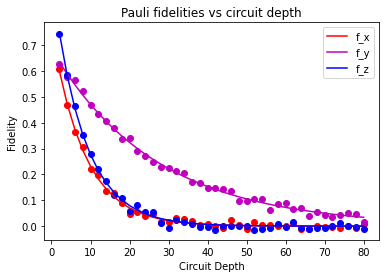

In [18]:
#plot each fold as two gates and scale so it starts at 2
xrange = np.multiply(2,range(1,1+folds)) 

#plot the measured fidelities vs gate depths
plt.plot(xrange, xfidelities, 'ro')
plt.plot(xrange, yfidelities, 'mo')
plt.plot(xrange, zfidelities, 'bo')

#fitting function
def Exp(t, c1, c2):
    return c1*np.exp(-t * c2)

#first guess for optimization
p0 = (1, .05)

#plot f_x
params, cv = scipy.optimize.curve_fit(Exp, xrange, xfidelities, p0)
ax, bx = params
line1, = plt.plot(xrange, ax*np.exp(np.multiply(-1*bx, xrange)), 'r', label="f_x")

#plot f_y
params, cv = scipy.optimize.curve_fit(Exp, xrange, yfidelities, p0)
ay, by = params
line2, = plt.plot(xrange, ay*np.exp(np.multiply(-1*by, xrange)), 'm', label="f_y")

#plot f_z
params, cv = scipy.optimize.curve_fit(Exp, xrange, zfidelities, p0)
az, bz = params
line3, = plt.plot(xrange, az*np.exp(np.multiply(-1*bz, xrange)), 'b', label="f_z");

#plot labels and parameters
plt.title("Pauli fidelities vs circuit depth")
plt.xlabel("Circuit Depth")
plt.ylabel("Fidelity")
plt.legend(handles=[line1, line2, line3]);

Comparing the extrapolated (measured) fidelities to the ideal ones

In [19]:
measured_fidelities = [1, math.exp(-bx), math.exp(-by), math.exp(-bz)]
print("Measured fidelities: ", measured_fidelities)
print("Ideal Fidelitites: ", ideal_fidelities)
print("Manhattan Norm: ", np.sum(np.abs(ideal_fidelities-measured_fidelities)))

Measured fidelities:  [1, 0.8875589513980132, 0.963254824026419, 0.8828476801893516]
Ideal Fidelitites:  [1.         0.88958519 0.96367614 0.88692044]
Manhattan Norm:  0.006520309615838493


The original fidelities are obtained from the model coefficients using Eq. S11
$$
-\frac{1}{2}\ln(\vec f) = M\vec \lambda
$$
Having measured $\vec f$, the solution $\vec \lambda$ is found such that
$$
\vert \vert M\lambda + \frac{1}{2}\ln(\vec f) \vert \vert_2
$$
is minimized

In [24]:
def lsq_fit(coeffs):
    return np.sum(np.square(np.dot(M,coeffs)+np.log(measured_fidelities)/2))

coeffs_guess = scipy.optimize.nnls(M, -.5*np.log(measured_fidelities))

#Compare guess to the actual values
print("Reconstructed model coefficients: ", coeffs_guess[0])
print("Ideal model coefficients: ", coeffs)

Reconstructed model coefficients:  [0.         0.01068989 0.05161141 0.00802876]
Ideal model coefficients:  [0, 0.01, 0.05, 0.0085]


Text(0, 0.5, 'coefficient')

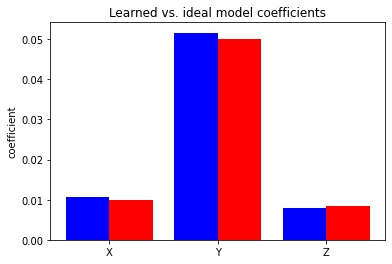

In [30]:
ax = np.arange(len(T)-1)
plt.bar(ax-.2,coeffs_guess[0][1::],.4, color='b')
plt.bar(ax+.2,coeffs[1::],.4, color='r')
plt.xticks(ax, T[1::])
plt.title("Learned vs. ideal model coefficients")
plt.ylabel("coefficient")